In this Mini Project, we will analyze the S&P500 Adjusted Close Price for the last 10 years.

- Write a Python program to download the historical data of S&P500 over that period.
- Show in a chart how the price of S&P 500 varied over that period. Plot Daily returns of the Index and identify periods of 5 worst historical monthly draw-downs.
- The Calmar Ratio is a drawdown related measure which equal to the compounded annual growth rate divided by the maximum drawdown.
                                                                       

In [44]:
import pandas as pd
from pandas_datareader import data, wb
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

In [45]:
start = datetime.datetime(2007, 6, 1)
end = datetime.datetime(2017, 6, 1)

data = data.DataReader('SPY',  'google', start, end)
data =data['Open']
#returns = np.log(data / data.shift(1))

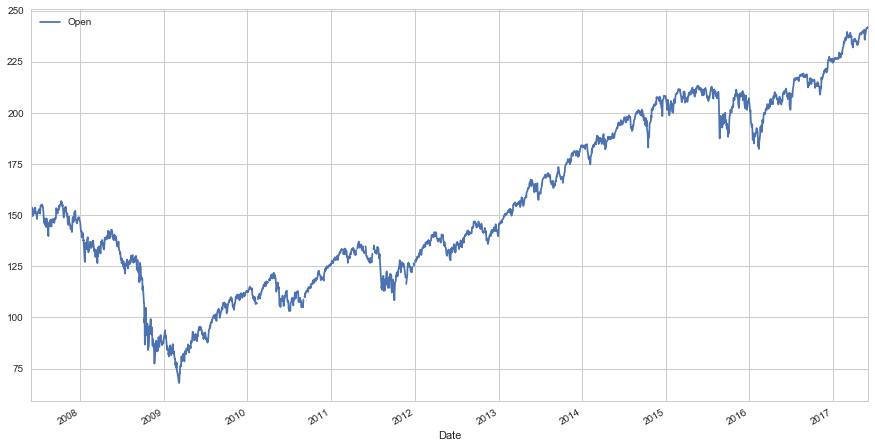

In [46]:
# Let's see a historical view of the closing price
data.plot(legend=True,figsize=(15,8))

**Daily Returns**

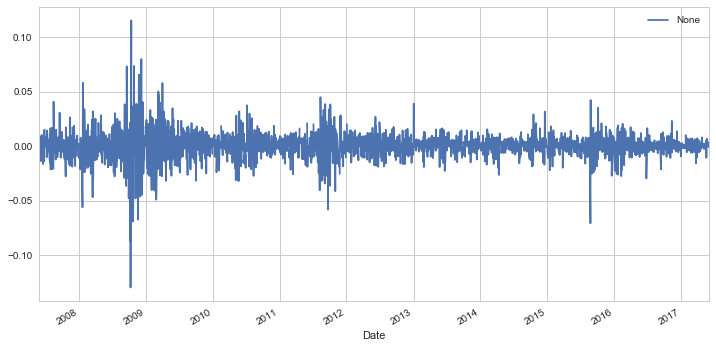

In [68]:
daily_return = data.pct_change()
daily_return.rename(columns={'Open': 'price'}, inplace=True)
daily_return.plot(legend=True, subplots=False,figsize=(12,6))

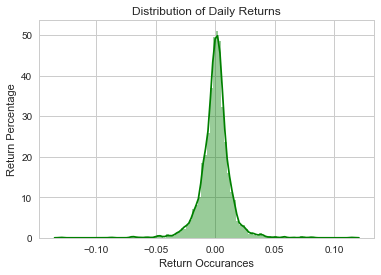

In [69]:
fig=sns.distplot(daily_return.dropna(),bins=100,color='green')
fig.set(xlabel='Return Occurances',ylabel='Return Percentage',title='Distribution of Daily Returns',)

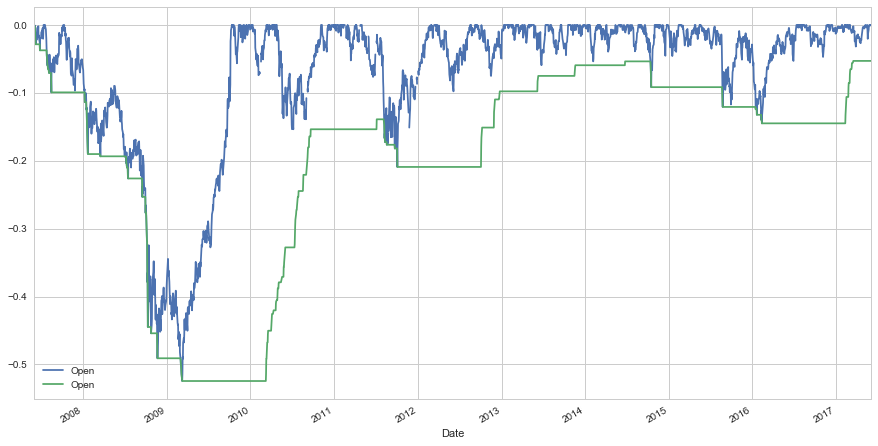

In [70]:
# Define a trailing 252 trading day window
window = 252

# Calculate the max drawdown in the past window days for each day 
rolling_max = data.rolling(window, min_periods=1).max()
daily_drawdown = data/rolling_max - 1.0

# Calculate the minimum (negative) daily drawdown
max_daily_drawdown = daily_drawdown.rolling(window, min_periods=1).min()

# Plot the results
daily_drawdown.plot(legend=True,figsize=(15,8))
max_daily_drawdown.plot(legend=True,figsize=(15,8))

# Show the plot
plt.show()

In [71]:
daily_return.head()

Date
2007-06-01         NaN
2007-06-04   -0.002210
2007-06-05    0.001303
2007-06-06   -0.005399
2007-06-07   -0.008829
dtype: float64

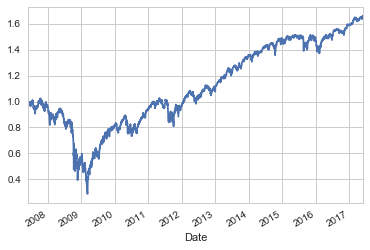

In [72]:
sp500 = daily_return.cumsum() + 1
sp500.plot()

In [78]:
#1) Annualised Return
 
days = (sp500.index[-1] - sp500.index[0]).days
cagr = ((((sp500[-1]) / sp500[1])) ** (365.0/days)) - 1
print ('CAGR =',str(round(cagr,4)*100)+"%")

CAGR = 5.22%


In [91]:
# performance.py

def create_drawdowns(sp500):
    """
    Calculate the largest peak-to-trough drawdown of the PnL curve
    as well as the duration of the drawdown. Requires that the 
    pnl_returns is a pandas Series.

    Parameters:
    pnl - A pandas Series representing period percentage returns.

    Returns:
    drawdown, duration - Highest peak-to-trough drawdown and duration.
    """

    # Calculate the cumulative returns curve 
    # and set up the High Water Mark
    # Then create the drawdown and duration series
    hwm = [0]
    eq_idx = sp500.index
    drawdown = pd.Series(index = eq_idx)
    duration = pd.Series(index = eq_idx)

    # Loop over the index range
    for t in range(1, len(eq_idx)):
        cur_hwm = max(hwm[t-1], sp500[t])
        hwm.append(cur_hwm)
        drawdown[t]= hwm[t] - sp500[t]
        duration[t]= 0 if drawdown[t] == 0 else duration[t-1] + 1
    return drawdown.max(), duration.max()

In [92]:
dd = create_drawdowns(sp500)
print(dd)

(0.73675681048238606, 893.0)


** Worst Drawdown was 73% and lasted 893 Days**

In [93]:
#Calmar Ratio is CAGR / MAXX
cr = .0522 / 0.736
print(cr)

0.07092391304347827


In [73]:
strat = pd.DataFrame([sp500, daily_return]).transpose()
strat = strat.dropna()
strat.head()

,0,1
Date,,
2007-06-04,0.997790,-0.002210
2007-06-05,0.999093,0.001303
2007-06-06,0.993694,-0.005399
2007-06-07,0.984866,-0.008829
2007-06-08,0.971274,-0.013592


- Consider a simple trading strategy where you invest 10,00 USD in the S&P500 every time the price closes above the 30 day moving average of daily close prices.
- Graphically represent the return profile of this strategy.
- Calculate and graphically represent Lake Ratio & Gain to Pain ratio of such a strategy.

In [95]:
import pandas as pd
from pandas_datareader import data, wb
start = datetime.datetime(2007, 6, 1)
end = datetime.datetime(2017, 6, 1)

data = data.DataReader('SPY',  'google', start, end)['Close']
data = pd.DataFrame(data)
data.rename(columns={'Close': 'price'}, inplace=True)
data.head()

,price
Date,
2007-06-01,154.08
2007-06-04,154.10
2007-06-05,153.49
2007-06-06,151.84
2007-06-07,149.10


In [96]:
data['SMA'] = data['price'].rolling(30).mean()
data.tail()

,price,SMA
Date,,
2017-05-25,241.76,238.002000
2017-05-26,241.71,238.308667
2017-05-30,241.50,238.539667
2017-05-31,241.44,238.792000
2017-06-01,243.36,239.122667


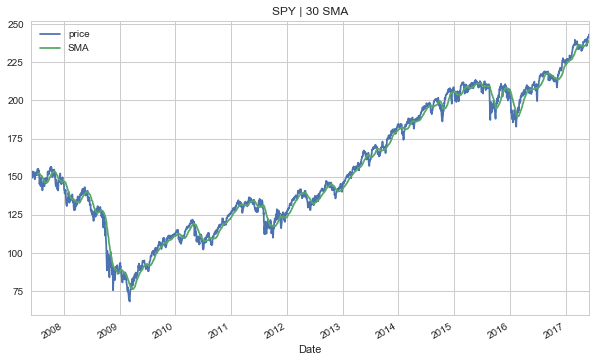

In [97]:
data.plot(title='SPY | 30 SMA',figsize=(10, 6))

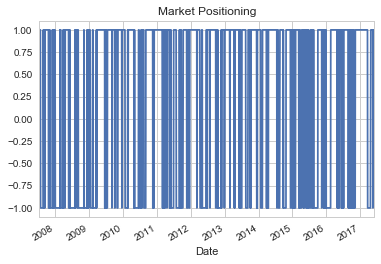

In [100]:
import numpy as np 
data['position'] = np.where(data['price'] > data['SMA'], 1, -1) #vector the siganl
data.dropna(inplace=True) 
data['position'].plot(ylim=[-1.1, 1.1], title='Market Positioning')

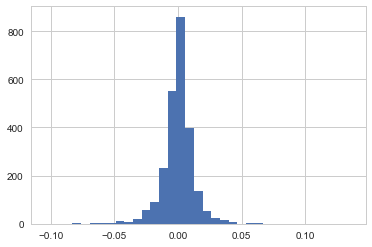

In [101]:
data['returns'] = np.log(data['price'] / data['price'].shift(1)) #calcs log returns of price
data['returns'].hist(bins=35) #plots returns in hist

In [102]:
data['strategy'] = data['position'].shift(1) * data['returns'] # returns when strategy is true
data[['returns', 'strategy']].sum() # sums for both stock and strategy

returns     0.452085
strategy   -0.532332
dtype: float64

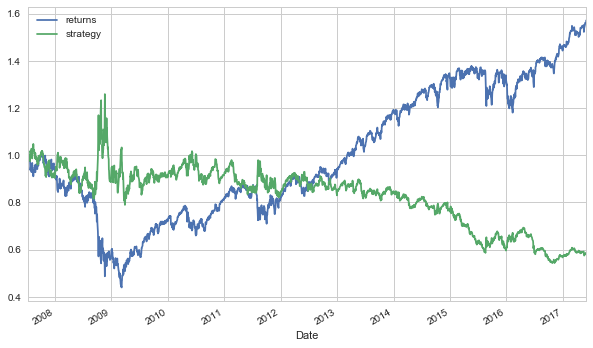

In [103]:
data[['returns', 'strategy']].cumsum().apply(np.exp).plot(figsize=(10, 6))

**Calculate and graphically represent Lake Ratio & Gain to Pain ratio of such a strategy**
 
Pain to Gain Ratio = (Total sum of all monthly returns/ABS (total of negative monthly returns)

In [109]:
st = data['strategy'].cumsum().apply(np.exp)
st.head()

Date
2007-07-13         NaN
2007-07-16    0.999871
2007-07-17    0.999354
2007-07-18    0.997546
2007-07-19    1.001421
Name: strategy, dtype: float64

rets = data['strategy']
rets.tail()

In [116]:
ABMR = np.sum(rets[rets < 0])
print(ABMR)             

-10.700715451515528


In [117]:
TSMR = -0.532332 * 100
print(TSMR)

-53.233200000000004


In [119]:
P2Gratio = TSMR / ABMR
print(P2Gratio)

4.974732786905445


** LAKE RATIO GRAPH **

In [123]:
lr = pd.DataFrame(st)
lr = lr.dropna()
lr.head()

,strategy
Date,
2007-07-16,0.999871
2007-07-17,0.999354
2007-07-18,0.997546
2007-07-19,1.001421
2007-07-20,0.991282


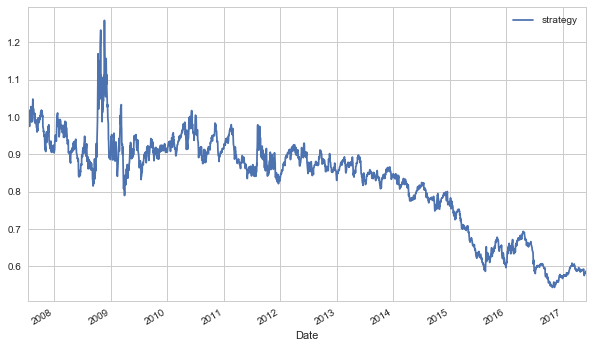

In [124]:
lr.plot(figsize=(10, 6))

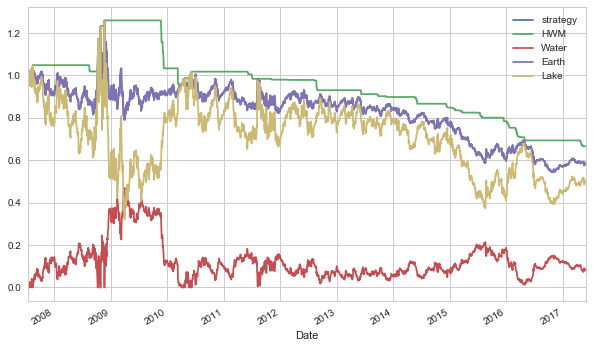

In [139]:
# Define a trailing 252 trading day window
window = 252

rolling_max = lr.rolling(window, min_periods=1).max()
lr.plot(figsize=(10, 6))
#rolling_max.plot(figsize=(10, 6))
plt.show()

In [140]:
lr["HWM"] = rolling_max
lr["Water"] = lr["HWM"] - lr["strategy"]
lr["Lake"] = lr["strategy"] - lr["Water"]
lr.head()

,strategy,HWM,Water,Earth,Lake
Date,,,,,
2007-07-16,0.999871,0.999871,0.000000,0.999871,0.999871
2007-07-17,0.999354,0.999871,0.000517,0.999354,0.998838
2007-07-18,0.997546,0.999871,0.002325,0.997546,0.995221
2007-07-19,1.001421,1.001421,0.000000,1.001421,1.001421
2007-07-20,0.991282,1.001421,0.010139,0.991282,0.981143


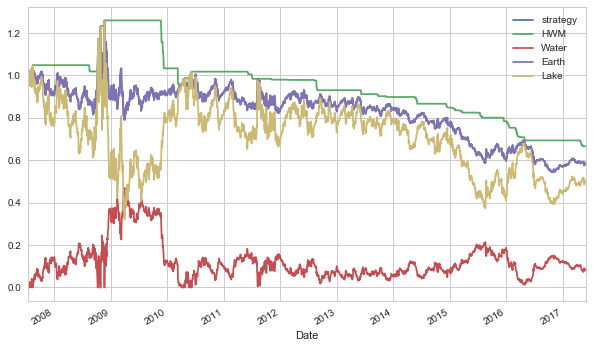

In [141]:
lr.plot(figsize=(10, 6))
#rolling_max.plot(figsize=(10, 6))
plt.show()

In [142]:
lr["Lake"].describe()

count    2487.000000
mean        0.708287
std         0.155633
min         0.320169
25%         0.579140
50%         0.744821
75%         0.815243
max         1.259215
Name: Lake, dtype: float64

In [145]:
lr["Water"].sum()

300.4002878565731

In [146]:
lr["strategy"].sum()

2061.909440043523

In [148]:
Lake_Ratio = lr["Water"].sum() - lr["strategy"].sum()
print(Lake_Ratio)

-1761.50915218695
